### nidaqmx-pythonの練習

- 2021/10現在研究室では公式以外の方の出したPyDAQmxを使用していた
    - そのせいかわからないがDAQによって複数チャネルの計測ができなそう（スレッドなど複雑な処理が必要そう）だと分かった
    - そのため公式への乗り換え及び公式ライブラリを用いた刺激プログラムを作成するためにこのnoteでは様々なことを試してみる
    - 役に立ちそうなドキュメント  
    https://nspyre.readthedocs.io/en/latest/guides/ni-daqmx.html  
    https://github.com/ni/nidaqmx-python  
    https://nidaqmx-python.readthedocs.io/en/latest/task.html  

In [2]:
#ライブラリの読み込み
import nidaqmx
import numpy as np
import time
from nidaqmx import stream_writers

In [3]:
system=nidaqmx.system.System.local()
#現在のドライババージョンを出力
system.driver_version

DriverVersion(major_version=19, minor_version=5, update_version=0)

In [4]:
for device in system.devices:
    print(device)

Device(name=Dev1)


In [5]:
import collections
isinstance(system.devices,collections.Sequence)

True

In [6]:
#緊急用Task終了用コード
task.close()

NameError: name 'task' is not defined

In [42]:
task=nidaqmx.Task()
task.ai_channels.add_ai_voltage_chan('Dev1/ai0:2')
data=task.read()
print(len(data))

3


In [5]:
#容易に複数チャンネルの取得ができることが分かったので
#タイミングを同期させて取得できることができるか試してみる
task=nidaqmx.Task()
#triggerのdataをai1,soundのdataをai0に入力
task.ai_channels.add_ai_voltage_chan('Dev1/ai0:1')
task.timing.cfg_samp_clk_timing(1000)


In [6]:
# Python 2.X does not have nonlocal keyword.
non_local_var = {'samples': []}

def callback(task_handle, every_n_samples_event_type,
             number_of_samples, callback_data):
    print('Every N Samples callback invoked.')

    samples = task.read(number_of_samples_per_channel=200)
    non_local_var['samples'].extend(samples)

    return 0

task.register_every_n_samples_acquired_into_buffer_event(
    200, callback)

task.start()

input('Running task. Press Enter to stop and see number of '
      'accumulated samples.\n')


Every N Samples callback invoked.
Every N Samples callback invoked.
Every N Samples callback invoked.
Every N Samples callback invoked.
Every N Samples callback invoked.
Running task. Press Enter to stop and see number of accumulated samples.



''

In [7]:
print(len(non_local_var['samples'][0]))

200


In [51]:
#緊急用Task終了用コード
task.close()


C:\Users\student\anaconda3\lib\site-packages\nidaqmx\task.py:461: ResourceWarning: Attempted to close NI-DAQmx task of name "_unnamedTask<1A>" but task was already closed.
  warnings.warn(


In [52]:
#複数チャンネルの電圧を同時計測するコード
task=nidaqmx.Task()
task.ai_channels.add_ai_voltage_chan('Dev1/ai0:1')
task.timing.cfg_samp_clk_timing(rate=20000,samps_per_chan=40000)
data=task.read(number_of_samples_per_channel=40000)
print(len(data))
task.close()


2


In [12]:
from matplotlib import pyplot as plt

C:\Users\student\Anaconda3\lib\site-packages\nidaqmx\task.py:105: ResourceWarning: Task of name "_unnamedTask<1>" was not explicitly closed before it was destructed. Resources on the task device may still be reserved.
  'reserved.'.format(self.name), DaqResourceWarning)


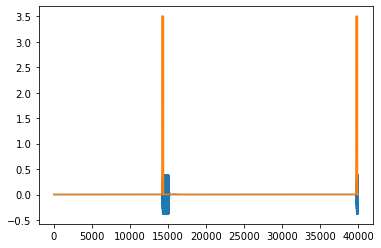

In [54]:
#triggerとsignalが計測できた
#電圧値も設定とほぼ同じ値だった
plt.plot(data[0])
plt.plot(data[1])
plt.show()

- 次に読み書きが同時にできるか
- input outputが同時にできないか試してみる
- できない場合にはmultiThreadingで処理を同期化する？→舘野先生の話ではそんなのしなくてもできるっぽい？


In [6]:
freq=2000
voltage=2
total_duration=2
duration=0.03 #[s]
samplerate=100000
write_array=np.zeros(samplerate*total_duration)
write_array[0:int(samplerate*duration)]=voltage*np.sin(2*np.pi*freq*np.arange(0,duration,1/(samplerate)))


In [7]:
print(write_array[int(samplerate*3/freq):int(samplerate*3/freq)+100])
print(type(write_array))
print(len(write_array))

[-1.46957616e-15  2.50666467e-01  4.97379774e-01  7.36249105e-01
  9.63507348e-01  1.17557050e+00  1.36909421e+00  1.54102649e+00
  1.68865585e+00  1.80965410e+00  1.90211303e+00  1.96457450e+00
  1.99605346e+00  1.99605346e+00  1.96457450e+00  1.90211303e+00
  1.80965410e+00  1.68865585e+00  1.54102649e+00  1.36909421e+00
  1.17557050e+00  9.63507348e-01  7.36249105e-01  4.97379774e-01
  2.50666467e-01  1.71450552e-15 -2.50666467e-01 -4.97379774e-01
 -7.36249105e-01 -9.63507348e-01 -1.17557050e+00 -1.36909421e+00
 -1.54102649e+00 -1.68865585e+00 -1.80965410e+00 -1.90211303e+00
 -1.96457450e+00 -1.99605346e+00 -1.99605346e+00 -1.96457450e+00
 -1.90211303e+00 -1.80965410e+00 -1.68865585e+00 -1.54102649e+00
 -1.36909421e+00 -1.17557050e+00 -9.63507348e-01 -7.36249105e-01
 -4.97379774e-01 -2.50666467e-01 -1.95943488e-15  2.50666467e-01
  4.97379774e-01  7.36249105e-01  9.63507348e-01  1.17557050e+00
  1.36909421e+00  1.54102649e+00  1.68865585e+00  1.80965410e+00
  1.90211303e+00  1.96457

In [23]:
# リソースが確保できない→エラーが起きた状態のままになってしまうのが原因そうなので初期化するのが一番よさそう
device=nidaqmx.system.device.Device("Dev1")
device.reset_device()

In [49]:
#緊急用Task終了用コード

task.stop()
task.close()

### 役立ちそうなドキュメント
- https://www.ni.com/ja-jp/support/documentation/supplemental/06/timing-and-synchronization-features-of-ni-daqmx.html
- https://www.ni.com/ja-jp/support/documentation/supplemental/06/learn-10-functions-in-ni-daqmx-and-handle-80-percent-of-your-dat.html

In [32]:
task=nidaqmx.Task()
#出力用チャンネルの生成
try:
    task.ao_channels.add_ao_voltage_chan('Dev1/ao0')
    #task.timing.cfg_samp_clk_timing(rate=samplerate,samps_per_chan=samplerate*total_duration)
    task.timing.cfg_samp_clk_timing(rate=samplerate,sample_mode=nidaqmx.constants.AcquisitionType.CONTINUOUS,samps_per_chan=samplerate*total_duration)
    print(task.channel_names)
    # 配列をそのまま書き込みしようとすると書き込み用のメモリが足りないと記載される→メモリの確保用のコマンドがどこかであるはず？
    # 単純にエラーが起きたあとにとまったことで起きたエラーだった
    # タスクの書き込みが一部しかできていないのはなぜ?→可能性タスクの書き込みが終わる前に出力されちゃっている?
    # タスク書き込み前に出力される場合にはどうすればいいんだろう→波形自体は指定したタイムスケール通りに出ている
    # まずはバッファの指定を試す
    print(task.out_stream.output_buf_size)
    print(task.write(write_array))
    #待つような関数を入れてみる？
    task.start()
    # channel_writerを使用してみる→だめだった
    # SignalStreamer=nidaqmx.stream_writers()
finally:
    if task:   
        task.stop()
        task.close()
        device=nidaqmx.system.device.Device("Dev1")
        device.reset_device()

['Dev1/ao0']
0
200000


In [35]:
import nidaqmx


with nidaqmx.Task() as task:
    task.ao_channels.add_ao_voltage_chan('Dev1/ao0')

    task.timing.cfg_samp_clk_timing(rate=1000,sample_mode=nidaqmx.constants.AcquisitionType.CONTINUOUS,samps_per_chan=5)

    print('1 Channel N Samples Write: ')
    print(task.write([1.1, 2.2, 3.3, 4.4, 5.5], auto_start=True))
    task.stop()
    

1 Channel N Samples Write: 


DaqError: The specified resource is reserved. The operation could not be completed as specified.
Task Name: _unnamedTask<14>

Status Code: -50103

In [22]:
from nidaqmx import stream_writers

In [75]:
#緊急用Task終了用コード

task.stop()
task.close()

In [19]:
# リソースが確保できない→エラーが起きた状態のままになってしまうのが原因そうなので初期化するのが一番よさそう
device=nidaqmx.system.device.Device("Dev1")
device.reset_device()

In [79]:
task=nidaqmx.Task()
#出力用チャンネルの生成
task.ao_channels.add_ao_voltage_chan('Dev1/ao0')
#task.timing.cfg_samp_clk_timing(rate=samplerate,samps_per_chan=samplerate*total_duration)
#バッファ上に波形を書き込む際に書き込み用のクラスをtaskのout_streamと結び付けてあげることが重要
analog_writer= stream_writers.AnalogSingleChannelWriter(task.out_stream)

In [69]:
#analog_writerを使用して書き込みを行う
task.timing.cfg_samp_clk_timing(rate=samplerate,samps_per_chan=samplerate*(total_duration+1))
#writeする際にバッファサイズが足りないというエラーが出た→バッファサイズ指定の関数が必要なのかな？
analog_writer.write_many_sample(write_array)

200000

In [70]:
task.start()

In [71]:
task.stop()

In [82]:
#波形の書き込みができた
task=nidaqmx.Task()
#出力用チャンネルの生成
task.ao_channels.add_ao_voltage_chan('Dev1/ao0')
#task.timing.cfg_samp_clk_timing(rate=samplerate,samps_per_chan=samplerate*total_duration)
#バッファ上に波形を書き込む際に書き込み用のクラスをtaskのout_streamと結び付けてあげることが重要
analog_writer= stream_writers.AnalogSingleChannelWriter(task.out_stream)
#analog_writerを使用して書き込みを行う
task.timing.cfg_samp_clk_timing(rate=samplerate,samps_per_chan=samplerate*(total_duration))
#writeする際にバッファサイズが足りないというエラーが出た→バッファサイズ指定の関数が必要なのかな？→単に前のtaskが残っていただけ
analog_writer.write_many_sample(write_array)
task.start()
#すぐに止めると電圧値が変な値で止まるため待機させる
task.wait_until_done()
task.stop()

In [14]:
#次は入出力の部分の設定を行う
#入力用のタスクと出力用のタスクが同時に行えるか検証→できなかった場合にはマルチスレッド処理が必要
# まずは読み込みと出力を同タスクでできるか→入力と出力のタイミングの確認
# 流れ→書き込み→スタート→読み込みで試してみる
task=nidaqmx.Task()
#出力用チャンネルの生成
task.ao_channels.add_ao_voltage_chan('Dev1/ao0')
#入力用チャンネルの生成
task.ai_channels.add_ai_voltage_chan('Dev1/ai0')
#サンプリングレートの設定
task.timing.cfg_samp_clk_timing(rate=samplerate,samps_per_chan=samplerate*(total_duration))
#波形の書き込み
#バッファ上に波形を書き込む際に書き込み用のクラスをtaskのout_streamと結び付けてあげることが重要
analog_writer= stream_writers.AnalogSingleChannelWriter(task.out_stream)
#analog_writerを使用して書き込みを行う
task.timing.cfg_samp_clk_timing(rate=samplerate,samps_per_chan=samplerate*(total_duration))
#writeする際にバッファサイズが足りないというエラーが出た→バッファサイズ指定の関数が必要なのかな？→単に前のtaskが残っていただけ
analog_writer.write_many_sample(write_array)
task.start()
# 読み込みを開始する
data=task.read(number_of_samples_per_channel=samplerate*total_duration)
#すぐに止めると電圧値が変な値で止まるため待機させる
task.wait_until_done()
#taskの終了
task.stop()
task.close()


DaqError: Task cannot contain a channel with the specified channel type, because the task already contains channels with a different channel type.
Create one task for each channel type.
Virtual Channel Name: Dev1/ao0
I/O Type Required for Virtual Channel: DAQmx_Val_AO
Physical Channel Name: Dev1/ai0
I/O Type Required for Virtual Channel: DAQmx_Val_AI

Task Name: _unnamedTask<1>

Status Code: -200559

In [1]:
import threading
import time
from multiprocessing.pool import ThreadPool

In [ ]:
"""
Task cannot contain a channel with the specified channel type, because the task already contains channels with a different channel type.
上の表記→どうやら同一タスクには読み込みと書き込みどちらかしか無理そう
→マルチスレッド化の処理を行う必要がある
"""

sleeptime = 0.6
#Dev1の初期化これ意外と大事
device=nidaqmx.system.device.Device("Dev1")
device.reset_device()
#複数処理用のコード（並列処理を行う)
pool = ThreadPool(processes=1)
result = pool.apply_async(input)
time.sleep(sleeptime) #大事な処理
worker = threading.Thread(target=output, args=())
worker.start()

worker.join()
record  = result.get()


In [27]:
freq=2000
voltage=2
total_duration=2
duration=0.03 #[s]
samplerate=100000
wave=np.zeros(samplerate*total_duration)
trigger=np.zeros(samplerate*total_duration)
wave[0:int(samplerate*duration)]=voltage*np.sin(2*np.pi*freq*np.arange(0,duration,1/(samplerate)))
trigger[0:int(0.01*samplerate)]=3.5*np.ones(int(0.01*samplerate))
write_array=np.array([wave,trigger])

In [32]:
print(type(write_array))

<class 'numpy.ndarray'>


In [40]:
# リソースが確保できない→エラーが起きた状態のままになってしまうのが原因そうなので初期化するのが一番よさそう
device=nidaqmx.system.device.Device("Dev1")
device.reset_device()

In [41]:
#波形の書き込みができた
task=nidaqmx.Task()
#出力用チャンネルの生成
task.ao_channels.add_ao_voltage_chan('Dev1/ao0:1')
#task.timing.cfg_samp_clk_timing(rate=samplerate,samps_per_chan=samplerate*total_duration)
#バッファ上に波形を書き込む際に書き込み用のクラスをtaskのout_streamと結び付けてあげることが重要
analog_writer= stream_writers.AnalogMultiChannelWriter(task.out_stream)
#analog_writerを使用して書き込みを行う
task.timing.cfg_samp_clk_timing(rate=samplerate,samps_per_chan=samplerate*(total_duration))
print(task.channel_names)
#writeする際にバッファサイズが足りないというエラーが出た→バッファサイズ指定の関数が必要なのかな？→単に前のtaskが残っていただけ
analog_writer.write_many_sample(write_array)
task.start()
#すぐに止めると電圧値が変な値で止まるため待機させる
task.wait_until_done()
task.stop()
#多チャンネルからの波形同時出力〇

['Dev1/ao0', 'Dev1/ao1']


In [39]:
task.close()

In [7]:
def input(samplerate=100000,total_duration=2):
    try:
        task=nidaqmx.Task()
        task.ai_channels.add_ai_voltage_chan('Dev1/ai0:1')
        task.timing.cfg_samp_clk_timing(rate=samplerate,samps_per_chan=samplerate*(total_duration))
        data=task.read(number_of_samples_per_channel=samplerate*total_duration)
        print(len(data))
        task.wait_until_done()
    finally:
        if task:
            task.stop()
            task.close()
    if data:
        return data
    else:
        return False


In [8]:
def make_waveform(samplerate=100000,voltage=2,total_duration=2,duration=0.03,freq=2000):
    wave=np.zeros(samplerate*total_duration)
    trigger=np.zeros(samplerate*total_duration)
    wave[0:int(samplerate*duration)]=voltage*np.sin(2*np.pi*freq*np.arange(0,duration,1/(samplerate)))
    trigger[0:int(0.01*samplerate)]=3.5*np.ones(int(0.01*samplerate))
    write_array=np.array([wave,trigger])
    return write_array

In [9]:
def output(samplerate=100000,total_duration=2):
    write_array=make_waveform()
    #波形の書き込みができた
    task=nidaqmx.Task()
    #出力用チャンネルの生成
    task.ao_channels.add_ao_voltage_chan('Dev1/ao0:1')
    #task.timing.cfg_samp_clk_timing(rate=samplerate,samps_per_chan=samplerate*total_duration)
    #バッファ上に波形を書き込む際に書き込み用のクラスをtaskのout_streamと結び付けてあげることが重要
    analog_writer= stream_writers.AnalogMultiChannelWriter(task.out_stream)
    #analog_writerを使用して書き込みを行う
    task.timing.cfg_samp_clk_timing(rate=samplerate,samps_per_chan=samplerate*(total_duration))
    print(task.channel_names)
    #writeする際にバッファサイズが足りないというエラーが出た→バッファサイズ指定の関数が必要なのかな？→単に前のtaskが残っていただけ
    analog_writer.write_many_sample(write_array)
    task.start()
    #すぐに止めると電圧値が変な値で止まるため待機させる
    task.wait_until_done()
    task.stop()

In [10]:
#読み書き用の関数ができたので並列化してみる
#sleeptimeを入れるとずれていそう
#sleeptime = 0.6
#Dev1の初期化これ意外と大事
device=nidaqmx.system.device.Device("Dev1")
device.reset_device()
#複数処理用のコード（並列処理を行う)
pool = ThreadPool(processes=1)
result = pool.apply_async(input)
#time.sleep(sleeptime) #大事な処理
worker = threading.Thread(target=output, args=())
worker.start()

worker.join()
record  = result.get()
pool.close()

['Dev1/ao0', 'Dev1/ao1']
2


In [57]:
print(len(record))
pool.close()

2


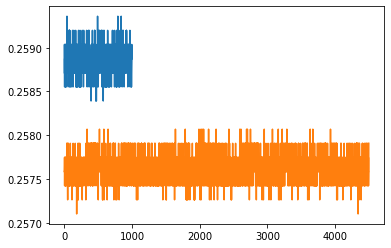

In [13]:
#triggerとsignalが計測できた
#出力した波形をそのまま計測
#電圧値も設定とほぼ同じ値だった
#PFIOなどを使ってトリガー同期させないと900/100000=0.009秒のずれが発生(9ms)
#刺激の生成までのラグだからそれでもよさそう？
#長内さんのプログラムだとPFIOを使って同期させてそうだから試してみる？
plt.plot(record[0][500:1500])
plt.plot(record[1][500:5000])
plt.savefig("input_and_output_at_the_sametime.png")
plt.show()

In [49]:
task.close()

In [64]:
from nidaqmx.task import *

In [73]:
trigger=task.triggers
reference_trigger=trigger.reference_trigger.cfg_dig_edge_ref_trig('Dev1/PFI0',100)

DaqError: Task specified is invalid or does not exist.
Status Code: -200088

In [75]:
#外部トリガーを設定して取得時間を調整できる？
def input_b(samplerate=100000,total_duration=2):
    try:
        task=nidaqmx.Task()
        task.ai_channels.add_ai_voltage_chan('Dev1/ai0:1')
        task.timing.cfg_samp_clk_timing(rate=samplerate,samps_per_chan=samplerate*(total_duration))
        trigger=task.triggers
        reference_trigger=trigger.reference_trigger.cfg_dig_edge_ref_trig('Dev1/PFI0',100)
        data=task.read(number_of_samples_per_channel=samplerate*total_duration)
        print(len(data))
        task.wait_until_done()
    finally:
        if task:
            task.stop()
            task.close()
    if data:
        return data
    else:
        return False


In [24]:
samplerate=10000
total_duration=2
write_array=np.ones(int(samplerate*total_duration))

In [25]:
# リソースが確保できない→エラーが起きた状態のままになってしまうのが原因そうなので初期化するのが一番よさそう
device=nidaqmx.system.device.Device("Dev1")
device.reset_device()

In [23]:
#波形の書き込みができた
task=nidaqmx.Task()
#出力用チャンネルの生成
task.ao_channels.add_ao_voltage_chan('Dev1/ao3')
#task.timing.cfg_samp_clk_timing(rate=samplerate,samps_per_chan=samplerate*total_duration)
#バッファ上に波形を書き込む際に書き込み用のクラスをtaskのout_streamと結び付けてあげることが重要
analog_writer= stream_writers.AnalogSingleChannelWriter(task.out_stream)
#analog_writerを使用して書き込みを行う
task.timing.cfg_samp_clk_timing(rate=samplerate,samps_per_chan=int(samplerate*(total_duration)))
#writeする際にバッファサイズが足りないというエラーが出た→バッファサイズ指定の関数が必要なのかな？→単に前のtaskが残っていただけ
analog_writer.write_many_sample(write_array)
task.start()
#すぐに止めると電圧値が変な値で止まるため待機させる
task.wait_until_done()
task.stop()